In [1]:
#### README:
# Para ejecutar este notebook, se debe tener instalado el paquete de python el paquete pandas 
# y el paquete geopandas. Para instalar geopandas seguir las instrucciones en https://towardsdatascience.com/geopandas-installation-the-easy-way-for-windows-31a666b3610f.
# El resto de los paquetes se instalan desde la consola (cmd o Simbolo del Sistema):
#   cd "<<Ruta donde esta el notebook>>"    
#   pip install -r requirements.txt
#
# La estructura de directorios debe ser la siguiente:
# <<path>>
# ├── Cuadras con Vecinos.ipynb
# ├── data
# │   ├── data_in
# │   │   ├── base_for_GIS_v2
# │   │   │   ├── base_for_GIS.dta
# │   │   └── Cuadras - Tercera Entrega
# │   │       ├── Veredas_Lineas.shp (incl. prj, sbn, sbx, y shx)
# │   ├── data_out
# │   │   ├── Cuadras que tocan cada buffer
# │   │   │   ├── buffer_100
# │   │   │   ├── buffer_200
# │   │   │   ├── buffer_300
# │   │   └── Mapas
#
# El path principal se setea en la variable <<path>>:
path = r"C:\Users\Nico\Documents\Proyectos\GIS Cruces - Application to Spillovers in Tax Compliance - Dic 22"

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
from pyproj import CRS
import time
start_time = time.time()

path_data_in = path + "/data/data_in"
path_data_out = path + "/data/data_out"

In [3]:
# importo el shape y paso a sistema de coordenadas proyectado para PBA
lines = gpd.read_file(
    path_data_in + "\Cuadras - Tercera Entrega\Veredas_Lineas.shp")

# Utilizo como CRS Gauss-Kruger Faja 5 para PBA. Con esto, las coordenadas se pasan a metros.
# Info en: https://www.ign.gob.ar/NuestrasActividades/ProduccionCartografica/sistemas-de-proyeccion
# Utilizo la proyección de proj4: https://epsg.io/18035
crs = CRS.from_proj4("+proj=tmerc +lat_0=-90 +lon_0=-60 +k=1 +x_0=5500000 +y_0=0")  
lines = lines.to_crs(crs)

,geometry,OBJECTID,FID_PARCEL,CIRC,COD_MZ,PC,LOCALIDAD,MZ,LADO
NUM_VEREDA,,,,,,,,,
1,"MULTILINESTRING ((5633546.210 6170396.000, 563...",158235,6308,5F,3,18B,Santos Lugares,65,I
10,"MULTILINESTRING ((5633164.680 6170396.710, 563...",158414,283,4G,3,21,Santos Lugares,56,P
100,"MULTILINESTRING ((5634244.590 6170523.970, 563...",164258,8540,5G,3,22A,Sáenz Peña,86,P
1000,"MULTILINESTRING ((5630482.770 6172579.140, 563...",258589,60242,4D,3,15A,Villa Bosch,127,P
1001,"MULTILINESTRING ((5630423.230 6172653.900, 563...",260914,60222,4D,3,16,Villa Bosch,126,P


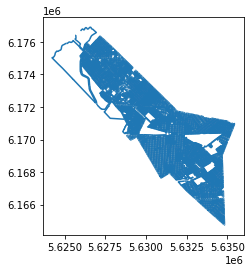

In [4]:
# Agrupo lineas por NUM_VEREDA
lines = lines.dissolve(by='NUM_VEREDA')
lines.plot()
lines.head(5)

In [16]:
lines.loc['1':'1'].buffer(100).explore()

In [5]:
dta = pd.read_stata(path_data_in + r"\base_for_GIS_v2\base_for_GIS.dta")
dta.head(5)

,id2,id,nro_cuenta,calle,numero,localidad,codigo_postal,T,tratado,num_cuadra,lado
0,0365411,2000001,200000/1,LAVALLE,9990,El Libertador,1657.0,NaN,NaN,6338,P
1,0181729,2000013,200001/3,LAVALLE,9990 5-F,El Libertador,1657.0,NaN,NaN,6338,P
2,0030937,2000028,200002/8,LAVALLE,9974,El Libertador,1657.0,NaN,NaN,6338,P
3,0034603,2000032,200003/2,LAVALLE,9958,El Libertador,1657.0,NaN,NaN,6338,P
4,0103592,2000047,200004/7,LAVALLE,9940,El Libertador,1657.0,NaN,NaN,6338,P


In [6]:
# Agrupo por 'num_cuadra' y obtengo:
# - Cantidad de cuadras de cada tratamiento
# - Cantidad de viviendas de cada tratamiento

cuadras = dta.groupby('num_cuadra').agg({'T': 'first', 'id': 'count', 'localidad':'first'})
cuadras = cuadras.reset_index().rename(columns={'index': 'num_cuadra', 'id': 'cant_viv'})

In [7]:
# Mergeo dta con datos gis
cuadras = lines.merge(cuadras, right_on='num_cuadra', left_on='NUM_VEREDA', how='left')
cuadras.head(10)

,geometry,OBJECTID,FID_PARCEL,CIRC,COD_MZ,PC,LOCALIDAD,MZ,LADO,num_cuadra,T,cant_viv,localidad
0,"MULTILINESTRING ((5633546.210 6170396.000, 563...",158235,6308,5F,3,18B,Santos Lugares,65,I,1,3.0,22.0,Santos Lugares
1,"MULTILINESTRING ((5633164.680 6170396.710, 563...",158414,283,4G,3,21,Santos Lugares,56,P,10,3.0,26.0,Santos Lugares
2,"MULTILINESTRING ((5634244.590 6170523.970, 563...",164258,8540,5G,3,22A,Sáenz Peña,86,P,100,2.0,13.0,Sáenz Peña
3,"MULTILINESTRING ((5630482.770 6172579.140, 563...",258589,60242,4D,3,15A,Villa Bosch,127,P,1000,0.0,35.0,Villa Bosch
4,"MULTILINESTRING ((5630423.230 6172653.900, 563...",260914,60222,4D,3,16,Villa Bosch,126,P,1001,3.0,19.0,Villa Bosch
5,"MULTILINESTRING ((5630369.150 6172706.380, 563...",262935,60198,4D,3,16,Villa Bosch,125,P,1002,3.0,25.0,Villa Bosch
6,"MULTILINESTRING ((5630393.810 6172797.530, 563...",266048,60183,4D,3,3,Villa Bosch,124,P,1003,NaN,4.0,Villa Bosch
7,"MULTILINESTRING ((5630448.110 6172744.140, 563...",264136,60206,4D,3,3,Villa Bosch,125,P,1004,NaN,4.0,Villa Bosch
8,"MULTILINESTRING ((5630502.280 6172691.370, 563...",262166,60230,4D,3,3,Villa Bosch,126,P,1005,NaN,2.0,Villa Bosch
9,"MULTILINESTRING ((5630596.360 6172637.620, 563...",260069,60073,4D,3,12A,Villa Bosch,120,I,1006,0.0,9.0,Villa Bosch


<AxesSubplot:>

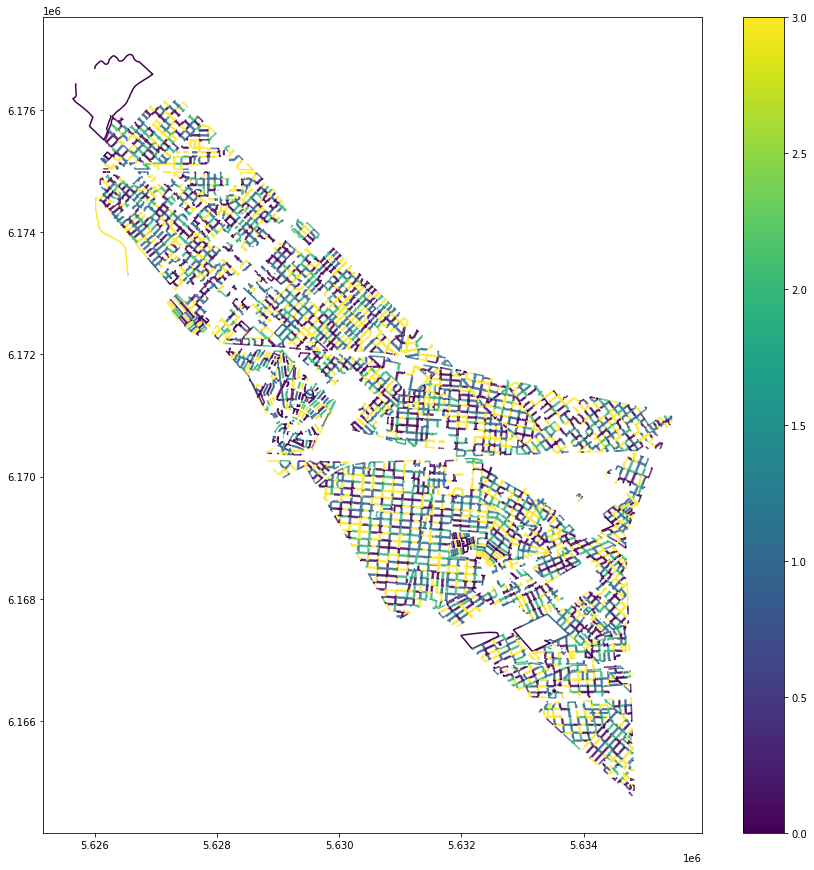

In [8]:
# Replico mapa del paper
cuadras.plot(column='T', figsize=(15,15), legend=True)

In [9]:
cuadras = cuadras.set_index('num_cuadra')
cuadras

,geometry,OBJECTID,FID_PARCEL,CIRC,COD_MZ,PC,LOCALIDAD,MZ,LADO,T,cant_viv,localidad
num_cuadra,,,,,,,,,,,,
1,"MULTILINESTRING ((5633546.210 6170396.000, 563...",158235,6308,5F,3,18B,Santos Lugares,65,I,3.0,22.0,Santos Lugares
10,"MULTILINESTRING ((5633164.680 6170396.710, 563...",158414,283,4G,3,21,Santos Lugares,56,P,3.0,26.0,Santos Lugares
100,"MULTILINESTRING ((5634244.590 6170523.970, 563...",164258,8540,5G,3,22A,Sáenz Peña,86,P,2.0,13.0,Sáenz Peña
1000,"MULTILINESTRING ((5630482.770 6172579.140, 563...",258589,60242,4D,3,15A,Villa Bosch,127,P,0.0,35.0,Villa Bosch
1001,"MULTILINESTRING ((5630423.230 6172653.900, 563...",260914,60222,4D,3,16,Villa Bosch,126,P,3.0,19.0,Villa Bosch
...,...,...,...,...,...,...,...,...,...,...,...,...
995,"MULTILINESTRING ((5630397.320 6172519.980, 563...",255753,60423,4D,3,16,Villa Bosch,134,P,3.0,36.0,Villa Bosch
996,"MULTILINESTRING ((5630327.850 6172702.230, 563...",262485,60370,4D,3,4B,Villa Bosch,131,P,NaN,11.0,Villa Bosch
997,"MULTILINESTRING ((5630382.560 6172648.840, 563...",260422,60387,4D,3,4B,Villa Bosch,132,P,NaN,8.0,Villa Bosch


In [10]:
def cuadras_que_tocan_buffer(cuadras, index, buffer, map=False, save=False, save_dataset=False, prints=False):
    pd.options.mode.chained_assignment = None

    temp = cuadras.loc[index:index,:]
    temp['geometry'] = temp.centroid.buffer(buffer)
    cuadras_que_tocan_buffer = cuadras.sjoin(temp[['geometry']], how='inner')

    if map:
        fig, ax = plt.subplots(1, 1)
        cuadras_que_tocan_buffer.plot(ax=ax)
        temp.plot(ax=ax, color='red', alpha=0.5, edgecolor='black')
        fig.show()
        if save:
            output = f"{path_data_out}/Mapas/cuadras_y_buffer_{index}_{buffer}.png"
            fig.savefig(output)
            if prints: print(f"{output} creado")

    if save_dataset:
        output = f"{path_data_out}/Cuadras que tocan cada buffer/buffer_{buffer}/cuadras_y_buffer_{index}_{buffer}.shp"
        cuadras_que_tocan_buffer.to_file(output)
        if prints: print(f"{output} creado")
    return cuadras_que_tocan_buffer

def completa_columnas_por_fila(cuadras, index, buffer, *args, **kwargs):
    
    # Genera dataframe con cuadras que tocan el buffer
    cuads_que_tocan_buffer = cuadras_que_tocan_buffer(cuadras, index, buffer, *args, **kwargs)

    # Calculo la cantidad de viviendas y cuadras de cada tratamiento y completo las columnas del dataframe
    tratados_cuads = 0
    tratados_vivs  = 0
    for trat in [0, 1, 2, 3, 4]:
        # Cantidades en Cuadras
        cuadras.loc[index, f'cuads_t{trat}_{buffer}'] = (
            cuads_que_tocan_buffer['T'] == trat).sum()
        tratados_cuads += cuadras.loc[index, f'cuads_t{trat}_{buffer}']

        # Cantidades en Viviendas
        cuadras.loc[index, f'vivs_t{trat}_{buffer}'] = cuads_que_tocan_buffer[
            cuads_que_tocan_buffer['T'] == trat].cant_viv.sum()
        tratados_vivs += cuadras.loc[index, f'vivs_t{trat}_{buffer}']

    # Totales de cuadras y viviendas
    cuadras.loc[index, f'cuads_all_{buffer}'] = cuads_que_tocan_buffer.shape[0]
    cuadras.loc[index, f'vivs_all_{buffer}']  = cuads_que_tocan_buffer['cant_viv'].sum()

    # Nans
    cuadras.loc[index, f'cuads_nan_{buffer}'] = (
            cuads_que_tocan_buffer['T'].isna()).sum()
    cuadras.loc[index, f'vivs_nan_{buffer}'] = cuads_que_tocan_buffer[
            cuads_que_tocan_buffer['T'].isna()].cant_viv.sum()

    # Valido que lo que hice está bien
    assert tratados_cuads + cuadras.loc[index, f'cuads_nan_{buffer}'] == cuadras.loc[index, f'cuads_all_{buffer}']
    assert tratados_vivs  + cuadras.loc[index, f'vivs_nan_{buffer}'] == cuadras.loc[index, f'vivs_all_{buffer}']

    return cuadras

def completa_columnas(cuadras, buffer, *args, **kwargs):
    warnings.simplefilter("ignore", UserWarning)

    for i in tqdm(cuadras.index):
        cuadras = completa_columnas_por_fila(cuadras, i, buffer, *args, **kwargs)
    return cuadras

In [11]:
cuadras = completa_columnas(cuadras, 100, save_dataset=True)
cuadras = completa_columnas(cuadras, 200, save_dataset=True)
cuadras = completa_columnas(cuadras, 300, save_dataset=True)

  1%|          | 67/6040 [00:50<1:14:56,  1.33it/s]


KeyboardInterrupt: 

In [ ]:
output_shape = path_data_out + r"\cuadras_buffers.shp"
output_dta   = path_data_out + r"\cuadras_buffers.dta"
cuadras.to_file(output_shape)
cuadras[[col for col in cuadras.columns if 'cuads_' in col or 'vivs_' in col
    ]].to_stata(output_dta)

In [38]:
import folium
k = '14'

m = lines.loc[k:k].buffer(100).explore()
folium.GeoJson(lines.loc[k:k].geometry,
    style_function=lambda feature: {
        'fillColor': "#f54242",
        'color' : "#f20000",
        'weight' : 1,
        'fillOpacity' : 0.2,
        }
).add_to(m)
m

In [29]:
import libpysal
import geopandas as gpd

gdf = gpd.read_file(r"C:\Users\Nico\Documents\MECON\2-Segmentacion\data\datain\paisporradio10\paisporradio10.shp")
sample = gdf[gdf['PROV'] == '02'].sample(700).reset_index()

c:\Users\Nico\AppData\Local\Programs\Python\Python310\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 319 disconnected components.
 There are 188 islands with ids: 0, 3, 6, 8, 17, 19, 21, 27, 31, 34, 35, 38, 39, 43, 44, 51, 58, 63, 65, 72, 73, 75, 81, 82, 83, 95, 98, 102, 103, 110, 112, 117, 118, 120, 126, 127, 129, 135, 136, 137, 138, 144, 146, 156, 167, 171, 173, 183, 185, 188, 191, 201, 205, 214, 220, 221, 222, 224, 225, 226, 228, 232, 236, 239, 240, 244, 245, 249, 252, 258, 273, 279, 286, 287, 288, 293, 298, 300, 301, 307, 310, 311, 319, 320, 324, 325, 329, 330, 331, 344, 346, 350, 351, 353, 354, 355, 364, 365, 372, 377, 378, 380, 382, 384, 388, 389, 391, 406, 409, 410, 411, 413, 414, 416, 422, 424, 428, 434, 437, 444, 445, 449, 453, 456, 457, 462, 477, 479, 483, 484, 486, 487, 489, 493, 497, 498, 503, 504, 506, 508, 515, 516, 517, 520, 524, 530, 533, 536, 538, 539, 545, 554, 559, 563, 567, 573, 575, 578, 584, 5

In [32]:
# create spatial weights matrix
W = libpysal.weights.Queen.from_dataframe(sample)

# get component labels
components = W.component_labels

combined_polygons = sample.dissolve(by=components)

c:\Users\Nico\AppData\Local\Programs\Python\Python310\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 319 disconnected components.
 There are 188 islands with ids: 0, 3, 6, 8, 17, 19, 21, 27, 31, 34, 35, 38, 39, 43, 44, 51, 58, 63, 65, 72, 73, 75, 81, 82, 83, 95, 98, 102, 103, 110, 112, 117, 118, 120, 126, 127, 129, 135, 136, 137, 138, 144, 146, 156, 167, 171, 173, 183, 185, 188, 191, 201, 205, 214, 220, 221, 222, 224, 225, 226, 228, 232, 236, 239, 240, 244, 245, 249, 252, 258, 273, 279, 286, 287, 288, 293, 298, 300, 301, 307, 310, 311, 319, 320, 324, 325, 329, 330, 331, 344, 346, 350, 351, 353, 354, 355, 364, 365, 372, 377, 378, 380, 382, 384, 388, 389, 391, 406, 409, 410, 411, 413, 414, 416, 422, 424, 428, 434, 437, 444, 445, 449, 453, 456, 457, 462, 477, 479, 483, 484, 486, 487, 489, 493, 497, 498, 503, 504, 506, 508, 515, 516, 517, 520, 524, 530, 533, 536, 538, 539, 545, 554, 559, 563, 567, 573, 575, 578, 584, 5

<AxesSubplot:>

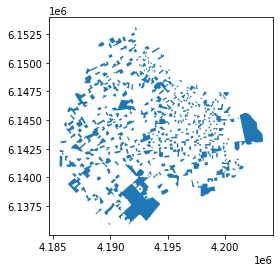

In [33]:
combined_polygons.plot()

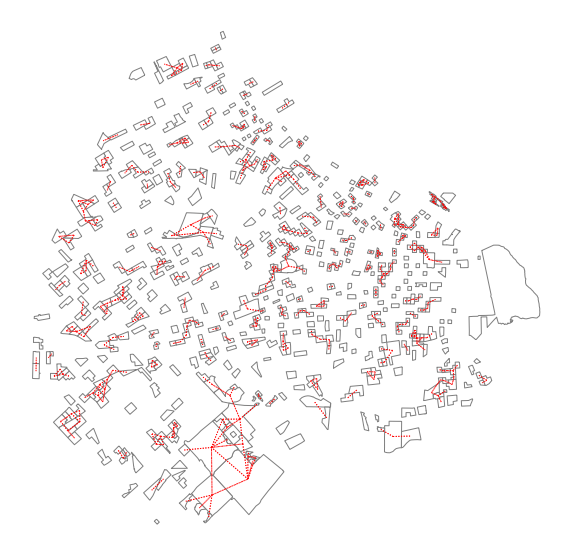

In [31]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

ax = sample.plot(edgecolor='grey', facecolor='w', figsize=(10,10))
f,ax = W.plot(sample, ax=ax,
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()


c:\Users\Nico\AppData\Local\Programs\Python\Python310\lib\site-packages\libpysal\weights\weights.py:1296: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))


KeyError: "None of [Int64Index([415, 191], dtype='int64')] are in the [index]"

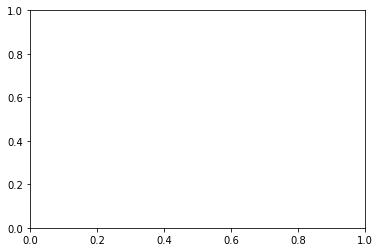

In [28]:
W.plot(sample)

In [26]:
W

In [60]:
import numpy as np
pd.DataFrame(np.unique(components, return_counts=True))


,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
1,4783,764,4,1,1,1,1,1,4,12,...,11,25,9,11,8,1,2,1,1,1


In [46]:
W.to_dataframe()

AttributeError: 'Queen' object has no attribute 'to_dataframe'